# **Goals** 
But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use Sqlite as a checkpointer, but other checkpointers, such as Postgres are available!

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file with UTF-8 encoding
load_dotenv(encoding='utf-8')

# Get the API key from environment
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# **Sqlite**
A good starting point here is the SqliteSaver checkpointer.

Sqlite is a small, fast, highly popular SQL database.

If we supply ":memory:" it creates an in-memory Sqlite database.

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [3]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file state_db already exists.
Error occurred while processing: state_db.


In [ ]:
import langgraph
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)




1.0.5


Let's re-define our chatbot.

In [8]:
from typing_extensions import Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState


model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}
    
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

    # Determine whether to end or summarize the conversation
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

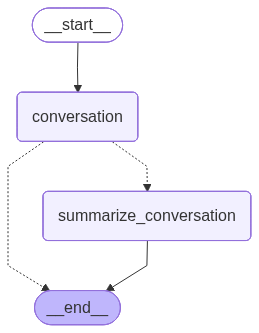

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you particularly enjoyed?


Let's confirm that our state is saved locally.

In [11]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='655dd13f-56d7-42b7-a99a-68b7ba6cc317'), AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-Cmm8H3y4ri2B9Z3YXcN0DFX8OCaXh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b1e5a-6a5a-7421-b532-2b528acb11ed-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au

Persisting state
Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.

In [12]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='655dd13f-56d7-42b7-a99a-68b7ba6cc317'), AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_e819e3438b', 'id': 'chatcmpl-Cmm8H3y4ri2B9Z3YXcN0DFX8OCaXh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b1e5a-6a5a-7421-b532-2b528acb11ed-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'au